# Hierarchical Bayesian LSTM

## Setup

### Imports

In [11]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pyro
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from src.utils.embeddings import FinBertEmbedder
from src.utils.news import create_lagged_news_sequences
from src.utils.returns import create_lagged_return_sequences
from src.modules.bayesian.hierarchical_lstm import HierarchicalBayesianModel
import matplotlib.pyplot as plt

### Constants

In [2]:
symbol = "TSLA"
lag = 5
predict_days = 5

## Dataset

### Loading

In [3]:
df = pd.read_csv(f'data/data_{symbol}.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df['2024-04-01':]

df = df[['text', 'return']]
df['text'] = df['text'].fillna('No news.')

### Feature Preparation

In [6]:
embedder = FinBertEmbedder()
embeddings = embedder.embed(df['text'].tolist())

In [7]:
news_X_lagged = create_lagged_news_sequences(embeddings, lag)

news_X_train, news_X_test = news_X_lagged[:-lag], news_X_lagged[-lag:]

### Target Preparation

In [8]:
scaler = StandardScaler()
return_X = scaler.fit_transform(df[['return']].values)

In [9]:
news_y_train = torch.tensor(return_X[lag:-predict_days], dtype=torch.float32).squeeze(-1)
news_y_test = torch.tensor(return_X[-predict_days:], dtype=torch.float32).squeeze(-1)

In [12]:
return_X_lagged, return_y = create_lagged_return_sequences(return_X, lag)
return_X_train, return_y_train = return_X_lagged[:-predict_days], return_y[:-predict_days]
return_X_test, return_y_test = return_X_lagged[-predict_days:], return_y[-predict_days:]

return_X_train = torch.tensor(return_X_train, dtype=torch.float32)
return_y_train = torch.tensor(return_y_train, dtype=torch.float32).squeeze()
return_X_test = torch.tensor(return_X_test, dtype=torch.float32)
return_y_test = torch.tensor(return_y_test, dtype=torch.float32).squeeze()

## Model Training

### Pipeline

In [33]:
pyro.set_rng_seed(42)
pyro.clear_param_store()

model = HierarchicalBayesianModel(768, 1)

optimizer = Adam({"lr": 1e-3})
guide = AutoDiagonalNormal(model)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

loss_log = []

for step in range(5000):
    loss = svi.step(news_X_train, return_X_train, return_y_train)
    loss_log.append(loss)
    if step % 100 == 0:
        print(f"Step {step} - Loss: {loss:.4f}")

Step 0 - Loss: 96408.7411
Step 100 - Loss: 90548.1448
Step 200 - Loss: 85376.5815
Step 300 - Loss: 79959.2689
Step 400 - Loss: 75407.2213
Step 500 - Loss: 70431.0174
Step 600 - Loss: 66046.1791
Step 700 - Loss: 61574.6126
Step 800 - Loss: 57175.4839
Step 900 - Loss: 52709.7270
Step 1000 - Loss: 48732.6748
Step 1100 - Loss: 44540.2404
Step 1200 - Loss: 40905.6635
Step 1300 - Loss: 37159.7081
Step 1400 - Loss: 33849.0737
Step 1500 - Loss: 30421.9013
Step 1600 - Loss: 27381.0767
Step 1700 - Loss: 24175.1099
Step 1800 - Loss: 21610.1177
Step 1900 - Loss: 18861.2931
Step 2000 - Loss: 16731.9532
Step 2100 - Loss: 14586.6454
Step 2200 - Loss: 12415.6360
Step 2300 - Loss: 10934.6736
Step 2400 - Loss: 9217.0324
Step 2500 - Loss: 7806.3235
Step 2600 - Loss: 6596.7790
Step 2700 - Loss: 5572.8678
Step 2800 - Loss: 4739.3714
Step 2900 - Loss: 4170.3842
Step 3000 - Loss: 3467.6170
Step 3100 - Loss: 2860.7820
Step 3200 - Loss: 2587.2328
Step 3300 - Loss: 2158.4065
Step 3400 - Loss: 1882.0464
Step 350

### Loss Visualization

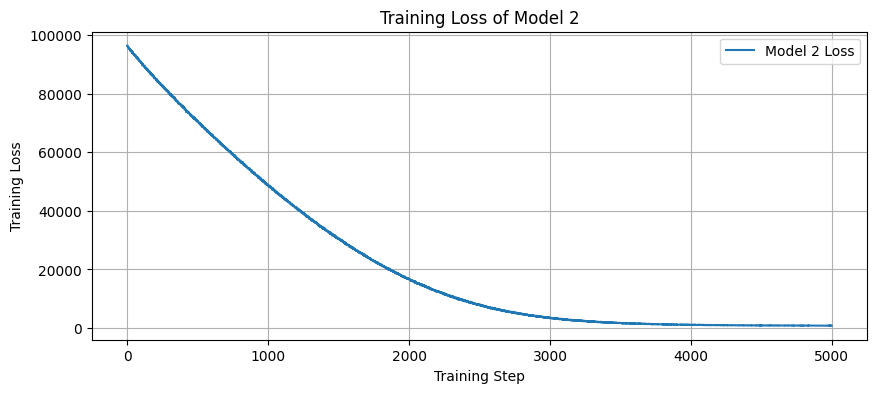

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(loss_log, label='Model 2 Loss')
plt.title("Training Loss of Model 2")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## Model Testing

### Pipeline

In [42]:
model = model.eval()
predictive = Predictive(model, guide=guide, num_samples=500)
samples = predictive(news_X_test, return_X_test)

posterior_preds = samples['model2_obs']

mean = posterior_preds.mean(0).detach().numpy()
std = posterior_preds.std(0).detach().numpy()

mean_rescaled = scaler.inverse_transform(mean.reshape(-1, 1)).flatten()
std_rescaled = std * scaler.scale_[0]

### Prediction Visualization

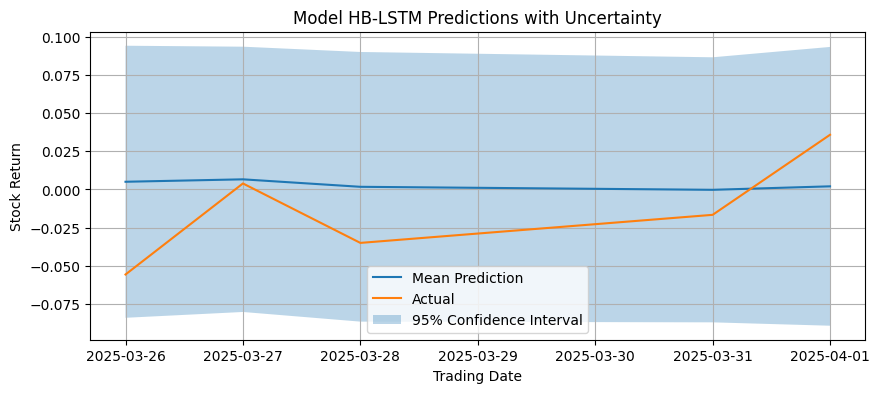

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(df['return'][-predict_days:].index, mean_rescaled, label='Mean Prediction')
plt.plot(df['return'][-predict_days:].index, df['return'][-predict_days:], label='Actual')
plt.fill_between(
    df['return'][-predict_days:].index,
    mean_rescaled - 2 * std_rescaled,
    mean_rescaled + 2 * std_rescaled,
    alpha=0.3, label='95% Confidence Interval'
)
plt.title('Model HB-LSTM Predictions with Uncertainty')
plt.ylabel("Stock Return")
plt.xlabel("Trading Date")
plt.grid(True)
plt.legend()
plt.show()